# Collection of Simple Random Sample from Alexa Top 1 Million

In [105]:
from random import randint
import pandas as pd
import socket

# List of top one million sites according to Alexa Analytics/Website Ranking
# https://s3.amazonaws.com/alexa-static/top-1m.csv.zip
top_sites = pd.read_csv('top-1m.csv', header=None)[1]

sample = {
    'Website Domain' : [],
    'IPv4 Address' : []
}

def create_sample(n=50): # n is sample size
    for i in range(n):
        # Get random number between 0 and 999,999
        random_index = randint(0, len(top_sites) - 1)

        # If the site has not already been selected, add it to our data set
        if not top_sites[random_index] in sample['Website Domain']:
            try:
                print("\033[0mGetting IPv4 Address for %s..." % top_sites[random_index])
                ipv4 = socket.gethostbyname(top_sites[random_index])
            except:
                # If we can't resolve the IP from the host name, replace it with a different host name
                print("\033[1mFailed. Selecting new site for sample.")
                i -= 1
                continue
            sample['Website Domain'].append(top_sites[random_index])
            sample['IPv4 Address'].append(ipv4)

create_sample()

# Save sample to a CSV file
dataset = pd.DataFrame.from_dict(sample)
dataset.to_csv('website_sample.csv')

Getting IPv4 Address for alphauniverse-latin.com...
Getting IPv4 Address for autozonepromotions.com...
Getting IPv4 Address for citroen.com.pe...
Getting IPv4 Address for ebook-gratuit.co...
Getting IPv4 Address for mika-clinic.com...
Getting IPv4 Address for jamzextra.com...
Getting IPv4 Address for kpe.ru...
Getting IPv4 Address for mpo-fr.ir...
Getting IPv4 Address for cyber.incheon.kr...
Getting IPv4 Address for tsmsco.ir...
Getting IPv4 Address for breaking.lv...
Getting IPv4 Address for futuretimes.co.kr...
Getting IPv4 Address for sellerlift.com...
Getting IPv4 Address for plcnet.org...
Getting IPv4 Address for werkenbijtransavia.com...
Getting IPv4 Address for thebeautysurfer.com...
Getting IPv4 Address for scuolacounseling.eu...
Getting IPv4 Address for naylampmechatronics.com...
Getting IPv4 Address for heartyrise.cn...
Getting IPv4 Address for cvmaker.fr...
Getting IPv4 Address for notable-quotes.com...
Getting IPv4 Address for panhim.com...
Getting IPv4 Address for dar.com.

# Determining Proportion of Websites Running AWS

In [106]:
import json, requests, ipaddress 

# List of IP Ranges (IPv4 and IPv6) owned by Amazon and used for AWS
# https://ip-ranges.amazonaws.com/ip-ranges.json
aws_ip_ranges = json.loads(requests.get('https://ip-ranges.amazonaws.com/ip-ranges.json').text)

# Determine if given IP address (ip_input) shows uo in AWS IPv4 Range
def check_aws(ip_input):
    # Compare given IP to all AWS IP addresses within AWS IPv4 Subnetwork
    for i in range(len(aws_ip_ranges['prefixes'])):
        site_ip = ipaddress.ip_address(ip_input)
        aws_subnet = ipaddress.ip_network(aws_ip_ranges['prefixes'][i]['ip_prefix'])
        
        # If IP is a part of AWS IPv4 Range, return True
        if site_ip in aws_subnet:
            return True
    return False

def get_aws_domains():
    aws_websites = []

    # Check every IP within our sample against AWS IPv4 Range
    for i in range(len(dataset)):
        if check_aws(dataset['IPv4 Address'][i]):
            aws_websites.append(dataset['Website Domain'][i])

    # Save dataset of AWS websites to a CSV file
    aws_df = pd.DataFrame({'AWS Websites':aws_websites})
    aws_df.to_csv('websites_using_aws.csv')
    
get_aws_domains()

# 1-Proportion Z-Test for Proportion of AWS to non-AWS Websites

population mean: 43.002372
sample mean: 42.388


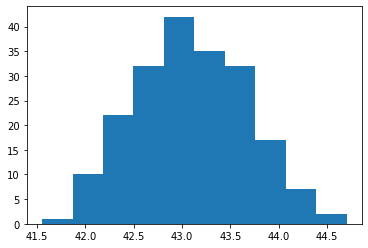

z-critical value: 1.959963984540054
point esimate: 42.523
Confidence interval: (41.70306406882683, 43.34293593117317)


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

# generate some random number to serve as our population
np.random.seed(10)
population_ages1 = stats.poisson.rvs(loc = 18, mu = 35, size = 150000)
population_ages2 = stats.poisson.rvs(loc = 18, mu = 10, size = 100000)
population_ages = np.concatenate((population_ages1, population_ages2))
print('population mean:', np.mean(population_ages))

np.random.seed(6)
sample_ages = np.random.choice(population_ages, size = 500)
print('sample mean:', np.mean(sample_ages))

np.random.seed(10)
samples = 200
point_estimates = [np.random.choice(population_ages, size = 500).mean()
                   for _ in range(samples)]

plt.hist(point_estimates)
plt.show()

np.random.seed(10)
sample_size = 1000
sample = np.random.choice(population_ages, size = sample_size)
sample_mean = sample.mean()

confidence = 0.95
z_critical = stats.norm.ppf(q = confidence + (1 - confidence) / 2)
print('z-critical value:', z_critical)                     

pop_stdev = population_ages.std()
margin_of_error = z_critical * (pop_stdev / np.sqrt(sample_size))
confint = sample_mean - margin_of_error, sample_mean + margin_of_error
print('point esimate:', sample_mean)
print('Confidence interval:', confint)